# ECC vs ECP for a noisy circle

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

### Create pointcloud

In [3]:
def generate_circle(NUMBER_OF_POINTS, seed=42, noise=False):
    point_cloud = []

    rng = np.random.default_rng(seed=seed)
    for a in np.linspace(0, 2*np.pi, num=NUMBER_OF_POINTS, endpoint=False):
        point = [np.cos(a), np.sin(a)]
        
        if noise:
            point += rng.normal(scale=noise, size=2)
        
        point_cloud.append(point)

    point_cloud = np.array(point_cloud)
    
    return point_cloud

def generate_noisy_points(NUMBER_OF_POINTS, xmin=-0.2, xmax=0.2, ymin=-0.2, ymax=0.2, seed=42):
    point_cloud = []
    
    rng = np.random.default_rng(seed=seed)
    
    for i in range(NUMBER_OF_POINTS):
        point_cloud.append([rng.uniform(xmin,xmax), 
                            rng.uniform(ymin,ymax)])

    point_cloud = np.array(point_cloud)
    
    return point_cloud

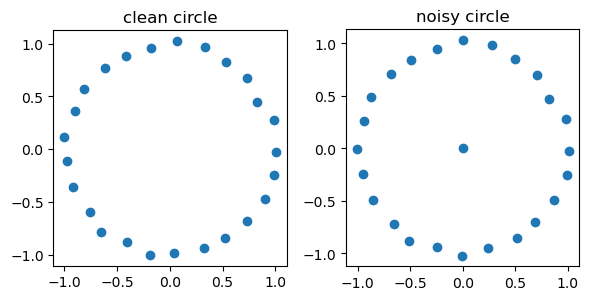

In [5]:
EPSILON = 10
DSIGMA = 0.025
NUMBER_OF_POINTS = 25

list_of_ECP = []

pointcloud = generate_circle(NUMBER_OF_POINTS, seed=42, noise=DSIGMA)

noisy_pointcloud = np.array(list(generate_circle(NUMBER_OF_POINTS-1, seed=42, noise=DSIGMA)) + [[0,0]])

fig, axs = plt.subplots(1, 2, figsize=(6,3))

axs[0].scatter(pointcloud[:,0], pointcloud[:,1])
axs[0].axis('scaled')
axs[0].set_title('clean circle')

axs[1].scatter(noisy_pointcloud[:,0], noisy_pointcloud[:,1])
axs[1].axis('scaled')
axs[1].set_title('noisy circle')

plt.tight_layout()
plt.show()

## ECC

In [6]:
from pyEulerCurves import ECC_from_pointcloud, plot_euler_curve

In [7]:
trans = ECC_from_pointcloud(epsilon=10, # max filtration
                            workers=2    # number of CPU cores
                           )

In [8]:
%%time
ecc = trans.fit_transform(pointcloud)

CPU times: user 8.7 ms, sys: 16.6 ms, total: 25.3 ms
Wall time: 7.56 s


In [9]:
%%time
noisy_ecc = trans.fit_transform(noisy_pointcloud)

CPU times: user 5.89 ms, sys: 9.28 ms, total: 15.2 ms
Wall time: 7.5 s


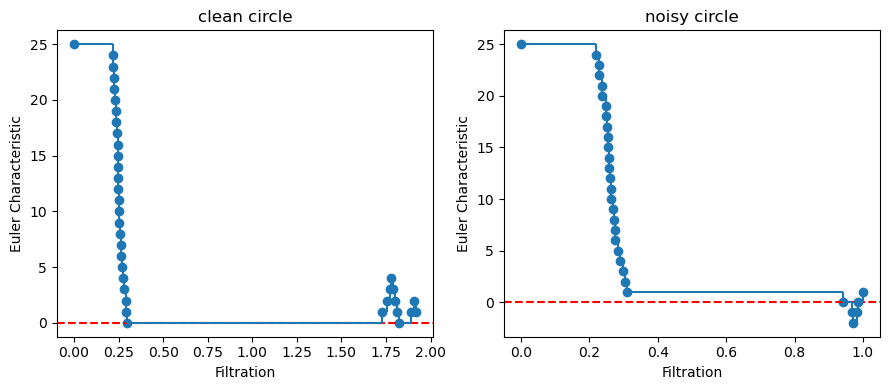

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(9,4))

axs[0].axhline(y=0, color='red', linestyle='--')
plot_euler_curve(ecc, with_lines=True, this_ax=axs[0])
axs[0].set_title('clean circle')

axs[1].axhline(y=0, color='red', linestyle='--')
plot_euler_curve(noisy_ecc, with_lines=True, this_ax=axs[1])
axs[1].set_title('noisy circle')

plt.tight_layout()
plt.show()

## ECP with radius and density

In [42]:
import src.purepyECP as pure
from src.bifiltration_utils import EC_at_bifiltration, plot_ECP, difference_ECP

In [22]:
vertex_filtrations = pure.gaussian_density(pointcloud, 0.2)*-1
noisy_vertex_filtrations = pure.gaussian_density(noisy_pointcloud, 0.2)*-1


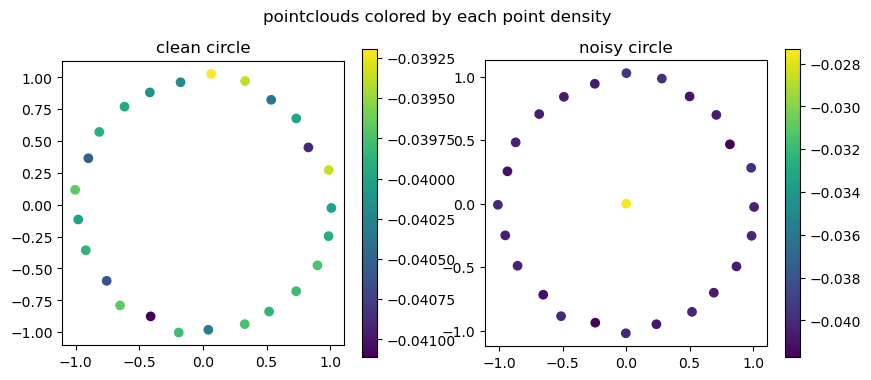

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

pts0 = axs[0].scatter(pointcloud[:,0], pointcloud[:,1], c=vertex_filtrations)
fig.colorbar(pts0, ax=axs[0])
axs[0].axis('scaled')
axs[0].set_title('clean circle')

pts1 = axs[1].scatter(noisy_pointcloud[:,0], noisy_pointcloud[:,1], c=noisy_vertex_filtrations)
fig.colorbar(pts1, ax=axs[1])
axs[1].axis('scaled')
axs[1].set_title('noisy circle')

fig.suptitle('pointclouds colored by each point density')
plt.show()

In [36]:
%%time
clean_contributions, num_simplices = pure.compute_local_contributions(pointcloud, EPSILON, vertex_filtrations)

100%|██████████| 25/25 [07:56<00:00, 19.05s/it]  

CPU times: user 7min 51s, sys: 3.48 s, total: 7min 55s
Wall time: 7min 56s


In [37]:
%%time
noisy_contributions, noisy_num_simplices = pure.compute_local_contributions(noisy_pointcloud, 
                                                                            EPSILON, noisy_vertex_filtrations)

100%|██████████| 25/25 [08:08<00:00, 19.52s/it]  

CPU times: user 8min 1s, sys: 3.51 s, total: 8min 5s
Wall time: 8min 8s


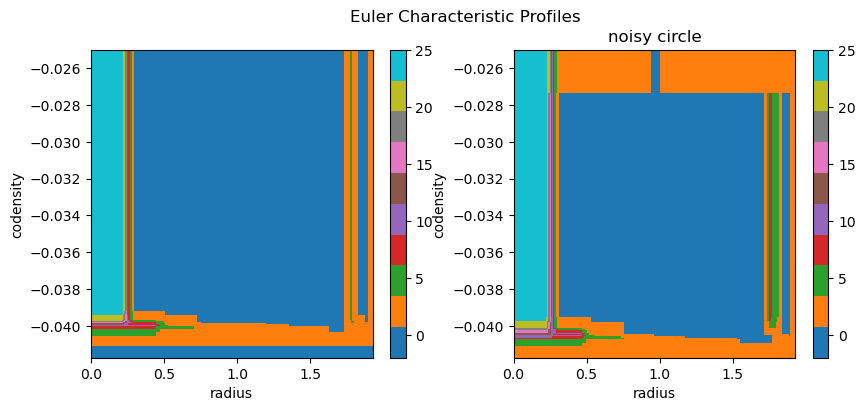

In [45]:
import matplotlib as mpl

fig, axs = plt.subplots(1, 2, figsize=(10,4))

f1max = max(max([c[0][0] for c in clean_contributions]), max([c[0][0] for c in noisy_contributions]))
f2max = max(max([c[0][1] for c in clean_contributions]),  max([c[0][1] for c in noisy_contributions]))
f2min = min(min([c[0][1] for c in clean_contributions]),  min([c[0][1] for c in noisy_contributions]))


plot_ECP(clean_contributions, (0, f1max, f2min, -0.025), axs[0], norm=mpl.colors.Normalize(vmin=-2, vmax=25),
         cmap='tab10', colorbar=True)
axs[0].set_xlabel('radius')
axs[0].set_ylabel('codensity')
axs[1].set_title('clean circle')

plot_ECP(noisy_contributions, (0, f1max, f2min, -0.025), axs[1], norm=mpl.colors.Normalize(vmin=-2, vmax=25),
         cmap='tab10', colorbar=True)
axs[1].set_xlabel('radius')
axs[1].set_ylabel('codensity')
axs[1].set_title('noisy circle')

fig.suptitle('Euler Characteristic Profiles')
plt.show()